In [5]:
import numpy as np 
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

def import_dataset_sampled(num_samples:int=100000):
    dataset = pd.read_csv("selfpost/rspct.tsv", sep="\t")
    le = LabelEncoder()
    vectorized_output_path = "selfpost/vectorized.npy"
    vectorized_labels_output_path = "selfpost/vectorized_labels.npy"
    with open(vectorized_output_path, "rb") as vect_X, open(vectorized_labels_output_path, "rb") as vect_y:
        X = np.load(vect_X, allow_pickle=True)
        y = np.load(vect_y, allow_pickle=True)
    assert (np.array(dataset["subreddit"][:100]) == y[:100]).all()
    y = le.fit_transform(y)
    if num_samples != -1:
        sample_indices = np.random.choice(X.shape[0], num_samples, replace=False)
        X = X[sample_indices]
        y = y[sample_indices]
        dataset = dataset.iloc[sample_indices, :]
    else:
        sample_indices = None
    return X, y, dataset, le, sample_indices

# X, y, dataset, le, sample_indices = import_dataset_sampled()
# assert (np.unique(y)).shape[0] == 1013
# dataset.shape, X.shape, y.shape

In [96]:
import umap
import umap.plot
import altair as alt
import pickle
from tqdm import tqdm 

def class_mass_centers(X, y, class_count, dims):
    _ndx = np.argsort(y)
    _id, _pos, g_count  = np.unique(y[_ndx], return_index=True, return_counts=True)
    g_sum = np.add.reduceat(X[_ndx], _pos, axis=0)
    g_mean = g_sum / g_count[:,None]
    return g_count, g_mean

    def display_umaped(X, y, n_neighbors, min_dist, metric="cosine", verbose=False):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric="cosine", verbose=verbose) 
    X = reducer.fit_transform(X)
#     with open("tmp\\dataset_dumps\\umaped_dataset_boe_X_y_dataset_le_sample_indices.pkl", "wb") as file:
#         pickle.dump((X, y, dataset, le, sample_indices), file)
    class_count = np.unique(y).shape[0]
    id_to_count, id_to_center = class_mass_centers(X, y, class_count, X.shape[1])
    
    dataframe = pd.DataFrame({
        "X": id_to_center[:, 0],
        "Y": id_to_center[:, 1],
        "count": id_to_count,
        "class": le.inverse_transform(np.arange(0,class_count))
    })
    return alt.Chart(dataframe).mark_circle().encode(
        alt.X("X"),
        alt.Y("Y"),
        alt.Color("class", legend=None),
        alt.Size("count"),
        tooltip= [alt.Tooltip("class"), alt.Tooltip("count")],
    ).interactive()
    

In [99]:
min_dist = 0.8
display_umaped(X, y, 20, min_dist, verbose=False)
# class_count = 1013
# id_to_count, id_to_center = class_mass_centers(X, y, class_count, X.shape[1])
# print(id_to_count, id_to_center)

0.27570922134460435
[[ 0.05271304  0.04177206 -0.15668953 ... -0.16065647 -0.01205617
   0.01008796]
 [ 0.14145061  0.08993324 -0.11799311 ... -0.34197932  0.09749986
  -0.10051761]
 [ 0.07768173  0.05184186 -0.17994204 ... -0.31380895  0.08328566
   0.02139767]
 ...
 [ 0.06520832 -0.01306901 -0.14864189 ... -0.22008692  0.09077452
   0.0441388 ]
 [ 0.09833506 -0.00345172 -0.10811505 ... -0.29009965  0.08501441
   0.01281524]
 [ 0.08470859  0.01541453 -0.05252408 ... -0.28216442  0.23596452
  -0.06239224]]


alt.Chart(...)

In [5]:
import xxhash 
xxhash.xxh128(np.array([1,2])).hexdigest()

'9cb99f86ae035f85657ce6e8d8ff657f'

In [4]:
X, y, dataset, le, sample_indices = import_dataset_sampled(-1)
X.shape, y.shape, dataset.shape

((1013000, 300), (1013000,), (1013000, 4))

In [13]:
sample_ind = np.random.choice(dataset.shape[0], 140000, replace=False)
val_ind = sample_ind[:20000]
train_ind = sample_ind[20000:40000]
pool_ind = sample_ind[40000:]
dataset_val = dataset.iloc[val_ind, :]
dataset_train = dataset.iloc[train_ind, :]
dataset_pool = dataset.iloc[pool_ind, :]
dataset_pool = dataset_pool.drop("subreddit", axis=1)

In [25]:
import pickle
with open("InteractiveDependencies/dataset_train.pkl", "wb") as train, open("InteractiveDependencies/dataset_val.pkl", "wb") as val, \
     open("InteractiveDependencies/dataset_pool.pkl", "wb") as pool:
    pickle.dump((dataset_train, X[train_ind]), train)
    pickle.dump((dataset_val, X[val_ind]), val)
    pickle.dump((dataset_pool, X[pool_ind]), pool)
    

In [18]:
dataset_pool.join(dataset.drop(["title", "id"], axis=1).set_index("selftext"), rsuffix="_right", on="selftext")

,id,title,selftext,subreddit
959204,4oq9o9,Can I use PsyPad to record the position of tou...,"Hey guys, I'm trying to make an experiment whe...",AcademicPsychology
325620,6pors4,Noob help request - attempting to run Lost min...,I apologize if these questions are dumb.. I've...,Roll20
359354,5j4kod,The Church Failed Us,I have never seen the church post pictures of ...,Philippines
976855,7k4ja9,The Sumire and Nue Snowball,So this just a theory manly based off the fact...,Naruto
95765,4ypdod,"Quakers first week home, need help.",So I need a little help... I just brought a ne...,parrots
...,...,...,...,...
68144,8huoa8,communism and technology,imagine its the distant future. technology has...,communism101
830738,54fb6h,"Failed date, feeling it was probably because I...","First off, I really need to delete tinder. But...",short
630614,8l6gmg,Problems with IPTV,"Hello, I am using an IPTV, it works on my phon...",Chromecast
230251,802p31,Ask for Input &gt; Match Text (Pattern),I’m writing a workflow for others to use. In t...,workflow


In [ ]:
with open("InteractiveDependencies/tolabeldataset.pkl", "rb") as file:
    dataset_partial = pickle.load(file)
dataset_partial.join(dataset.drop(["title", "id"], axis=1).set_index("selftext"), rsuffix="_right", on="selftext")
with open("InteractiveDependencies/tolabeldataset.pkl", "wb") as file:
    dataset_partial = pickle.dump(dataset_partial, file)

In [22]:
import altair as alt
from vega_datasets import data

source = data.cars()

line = alt.Chart(source).mark_line().encode(
    x='Year',
    y='mean(Miles_per_Gallon)'
)

band = alt.Chart(source).mark_errorband(extent='ci').encode(
    x='Year',
    y=alt.Y('Miles_per_Gallon', title='Miles/Gallon'),
)
source

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,1970-01-01,USA
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,1970-01-01,USA
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,1970-01-01,USA
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,1970-01-01,USA
4,ford torino,17.0,8,302.0,140.0,3449,10.5,1970-01-01,USA
...,...,...,...,...,...,...,...,...,...
401,ford mustang gl,27.0,4,140.0,86.0,2790,15.6,1982-01-01,USA
402,vw pickup,44.0,4,97.0,52.0,2130,24.6,1982-01-01,Europe
403,dodge rampage,32.0,4,135.0,84.0,2295,11.6,1982-01-01,USA
404,ford ranger,28.0,4,120.0,79.0,2625,18.6,1982-01-01,USA


In [47]:
X, y, dataset, le, sample_indices = import_dataset_sampled(-1)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.99, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

In [58]:
from modules.models.Linear import LogReg
from modules.models.Wraps import TorchClassifierWrap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from modAL.uncertainty import entropy_sampling, uncertainty_sampling, margin_sampling
from modAL.models import ActiveLearner
from modules.ActiveLearning.Samplings import random_sampling
from modules.ActiveLearning.Heuristics import disputable_points
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
figure(figsize=(8, 6), dpi=150)

sampling_labels = ["Confidence", "Margin", "Entropy",
             "Random", "Most Disputable points"]
sampling_funcs = [uncertainty_sampling, margin_sampling, entropy_sampling, random_sampling, disputable_points]
def plot_metric():
    figure(figsize=(8, 6), dpi=150)
    for sampling, sampling_label in zip(sampling_funcs[:4], sampling_labels[:4]):
        model = TorchClassifierWrap(LogReg(), 50, 300, 500)
        learner = ActiveLearner(
                estimator=model,
                query_strategy=sampling,
                X_training=X_train, y_training=y_train
            )
        initial_size = X_train.shape[0] // 1000 * 1000
        query_size = 500
        iterations = 10
        plot_x = np.arange(initial_size, initial_size + query_size * (iterations + 1), query_size)
        metric = []
        for itr in range(iterations):
            metric.append(accuracy_score(learner.predict(X_val), y_val))
            query_idx, query_inst = learner.query(X_pool, n_instances=query_size)
            learner.estimator = TorchClassifierWrap(LogReg(), 50, 300, 500)
            learner.teach(query_inst, y_pool[query_idx])
        metric.append(accuracy_score(learner.predict(X_val), y_val))
        plt.plot(plot_x, metric, label=sampling_label)
        plt.legend()
    plt.show()

<Figure size 1200x900 with 0 Axes>

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.61it/s]


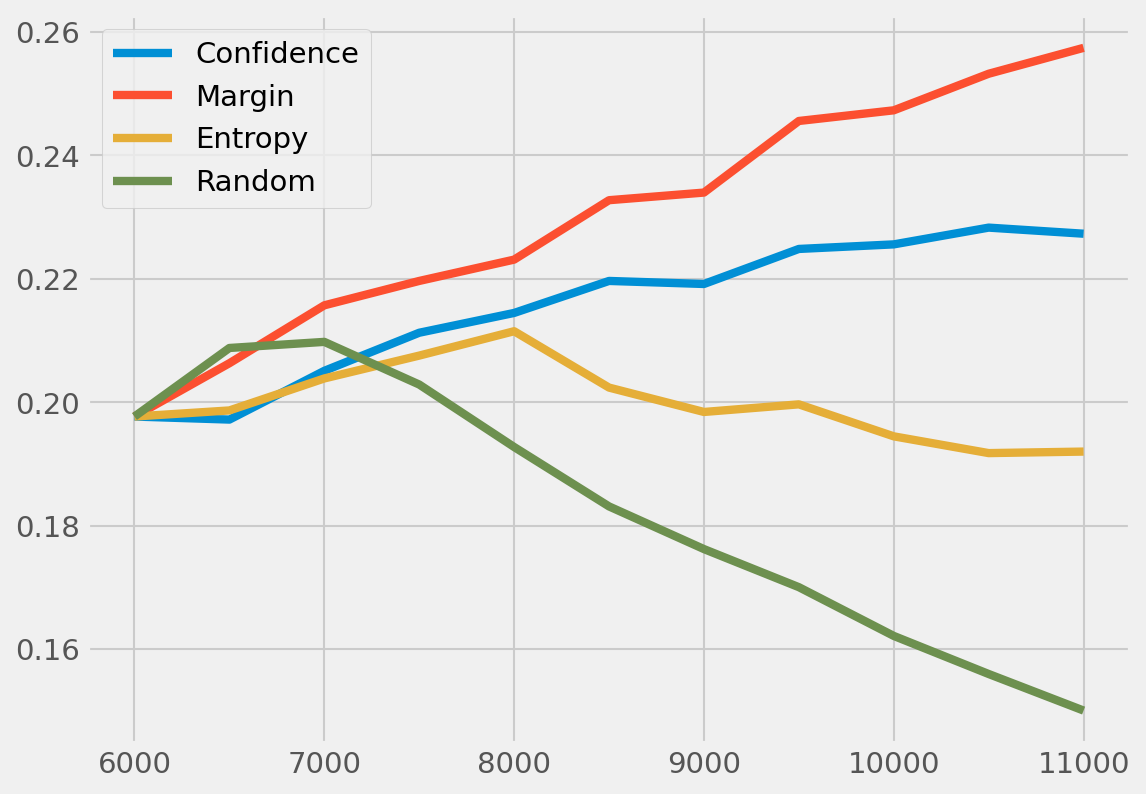

In [59]:
plot_metric()